# Import Library and ENV Directory

In [16]:
from sklearn.model_selection import train_test_split
import os
import pathlib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from tensorflow import keras
import pandas as pd
import shutil
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tensorflow.keras.optimizers import Adam


In [17]:
import sys
import sklearn
# Print versions of libraries and Python
print(f'Python version: {sys.version}')
print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

Python version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
TensorFlow version: 2.15.0
NumPy version: 1.26.4
scikit-learn version: 1.2.2


In [18]:
# Set the root path and working path
ROOT_PATH = pathlib.Path('/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset')
WORKING_PATH = pathlib.Path('/kaggle/working/')

In [19]:
# Dir of model, history csv
TRAINED_DATASET = '/kaggle/input/pretrain-model/pretrain_model'

## Detail of dataset

In [20]:
label_names = []
def countFileType(path):
    image_type = os.listdir(path)

    for im_type in image_type:
        label_names.append(im_type)
        folder_path = os.path.join(path, im_type)
        if os.path.isdir(folder_path):
            image_files =  [file for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg'))]
            if image_files:
                print(f'{im_type}: {len(image_files)}')
                
countFileType(ROOT_PATH)

metal: 410
glass: 501
paper: 594
trash: 137
cardboard: 403
plastic: 482


## The "Garbage Image Dataset" reveals a noticeable imbalance in the distribution of its image categories:

cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images
Imagine teaching a child to identify animals by showing them 95 pictures of cats and just 5 pictures of dogs. They'd probably start to think most pets are cats due to the sheer number of cat images they've seen. Similarly, in our dataset, a machine learning model might become adept at identifying "paper" but may not be as skilled with "trash" because of the fewer examples.

This can lead to:

1️⃣ Bias: The model might lean towards predicting "paper" often because it's seen it more during training.

2️⃣ Generalization Issues: If we deploy our model in a real-world scenario where "trash" items are just as common as "paper" items, our model might not perform well.

3️⃣ Accuracy Deception: The model could seem highly accurate if it keeps guessing the dominant class, but it might be weak in detecting underrepresented classes like "trash".

To create an efficient classifier, addressing this imbalance is crucial.

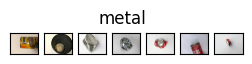

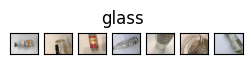

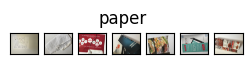

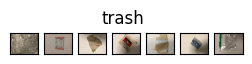

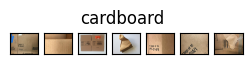

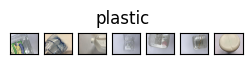

In [21]:
def showPhotoSample(path):
    image_type = os.listdir(path)
    for im_type  in image_type:
      fig, axs = plt.subplots(1, 7, figsize=(3,0.7))
      fig.suptitle(im_type)
      imageType_path = os.path.join(path, im_type)
      image_file = os.listdir(imageType_path)
      image_file = image_file[:7]
      for i, image in enumerate(image_file):
        with Image.open(os.path.join(imageType_path, image)) as img:
            axs[i].imshow(img)
            axs[i].set(xticks=[], yticks = [])
showPhotoSample(ROOT_PATH)

# Preprocessing

In [22]:
# To dataframe

data = []

for garbage_type in os.listdir(ROOT_PATH):
    for image in os.listdir(os.path.join(ROOT_PATH, garbage_type)):
        data.append((os.path.join(ROOT_PATH, garbage_type, image), garbage_type))
        
data_frame = pd.DataFrame(data, columns=['path', 'label'])

train_df, val_df = train_test_split(data_frame, test_size=0.2, random_state=42, stratify=data_frame['label'])

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest',
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  
    x_col="path",                    
    y_col="label",                       
    target_size=(384,384),              
    batch_size=32,                       
    class_mode='categorical',            
    seed=42,                             
    shuffle=False                        
)


# Generate validation batches from the validation dataframe
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,                    
    x_col="path",                    
    y_col="label",                       
    target_size=(384,384),              
    class_mode='categorical',            
    seed=42,                             
    shuffle=False                        
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


# Process

## Load model and history

In [24]:
loaded = False
try:
    shutil.copy(os.path.join(TRAINED_DATASET, 'modelTrained.keras'), '/kaggle/working/modelTrained.keras')
    model = tf.keras.models.load_model(os.path.join(WORKING_PATH, 'modelTrained.keras'))
    historyDF = pd.read_csv(os.path.join(TRAINED_DATASET, 'training_history.csv'))
    loaded = True
except ValueError:
    print('Load model failed')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 180 variables whereas the saved optimizer has 76 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


## Initilization Model

In [25]:
if not loaded:
    # Load the pre-trained ResNet50V2 model
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(384,384, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(list(train_generator.class_indices.keys())), activation='softmax')(x)

    # Combine the base model and custom layers into a new model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    # Define the callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss',  # Adjusted to monitor validation loss
            factor=0.2,
            patience=3,
            verbose=1,
            min_lr=1e-6
        ),
        EarlyStopping(
            monitor='val_loss',  # Adjusted to monitor validation loss
            patience=5,
            verbose=1,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=os.path.join(WORKING_PATH, 'best_model.keras'),  # Adjusted filename extension to .h5
            monitor='val_loss',  # Adjusted to monitor validation loss
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(
            log_dir=os.path.join(WORKING_PATH, 'logs'),
            histogram_freq=1
        )
    ]

In [26]:
# Handle imbalanced by Class Weight
class_labels = np.unique(train_generator.classes)
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_generator.classes)
class_weights = dict(zip(train_generator.class_indices.values(), weights))
print(class_weights)
print(list(train_generator.class_indices.keys()))

{0: 1.0460662525879918, 1: 0.8399833748960931, 2: 1.026930894308943, 3: 0.7091228070175438, 4: 0.8748917748917749, 5: 3.062121212121212}
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Training Model

In [27]:
if not loaded:
    for layer in model.layers[-38:]:
        layer.trainable = True
        
    history = model.fit(
       train_generator,
       steps_per_epoch=train_generator.samples // train_generator.batch_size,
       epochs=150,
       validation_data=validation_generator,
       verbose=1,
       validation_steps=validation_generator.samples // validation_generator.batch_size,
       callbacks=callbacks,
       class_weight=class_weights
    )

## Save model, save history

In [28]:
if not loaded:
    # Convert training history to a DataFrame
    historyDF = history.history
    history_df = pd.DataFrame(historyDF)

    # Save training history to a CSV file
    history_df.to_csv('/kaggle/working/training_history.csv', index=False)
    model.save(os.path.join(WORKING_PATH, 'modelTrained.h5'))
    model.save(os.path.join(WORKING_PATH, 'modelTrained.keras'))

# Visualize result

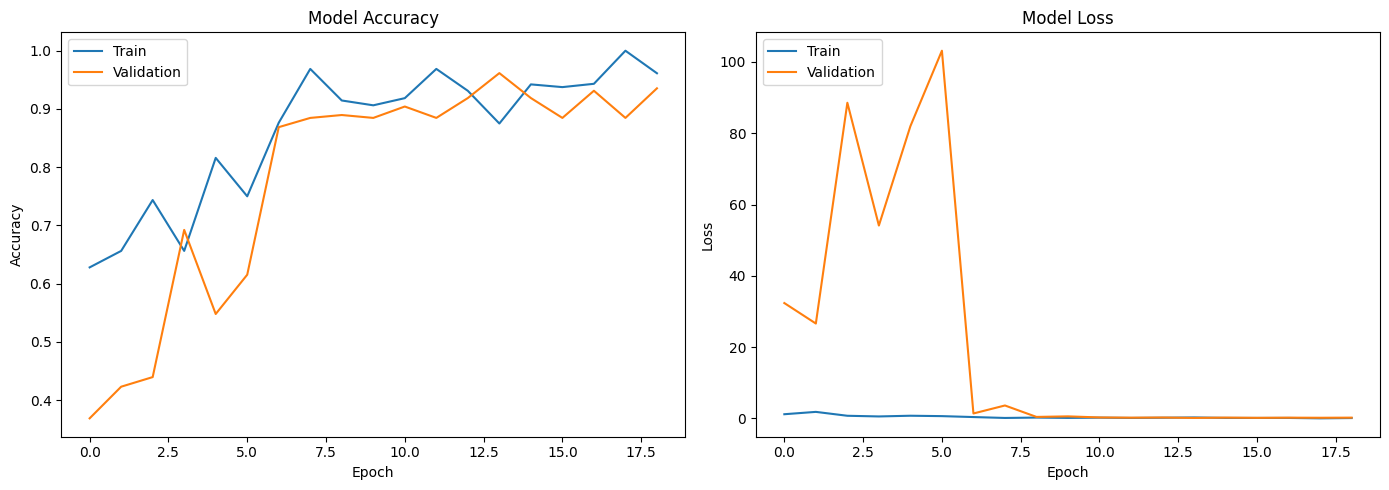

In [29]:
# Draw the plots
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(historyDF['accuracy'])
plt.plot(historyDF['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyDF['loss'])
plt.plot(historyDF['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4:08 17s/step - accuracy: 0.9062 - loss: 0.2133 - precision: 0.9355 - recall: 0.9062

I0000 00:00:1721146804.725529      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9090 - loss: 0.2734 - precision: 0.9251 - recall: 0.8823
Validation Loss: 0.2631
Validation Accuracy: 0.9209
Validation Precision: 0.9336
Validation Recall: 0.8893


In [31]:
image_type = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

xi = None
yi = None

X_test = []
y_test = []
for _ in range(len(validation_generator)):
    xi, yi = next(validation_generator)
    X_test.extend(xi)
    y_test.extend(yi)

class_indices = validation_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

Accuracy of test predictions: 100.00%


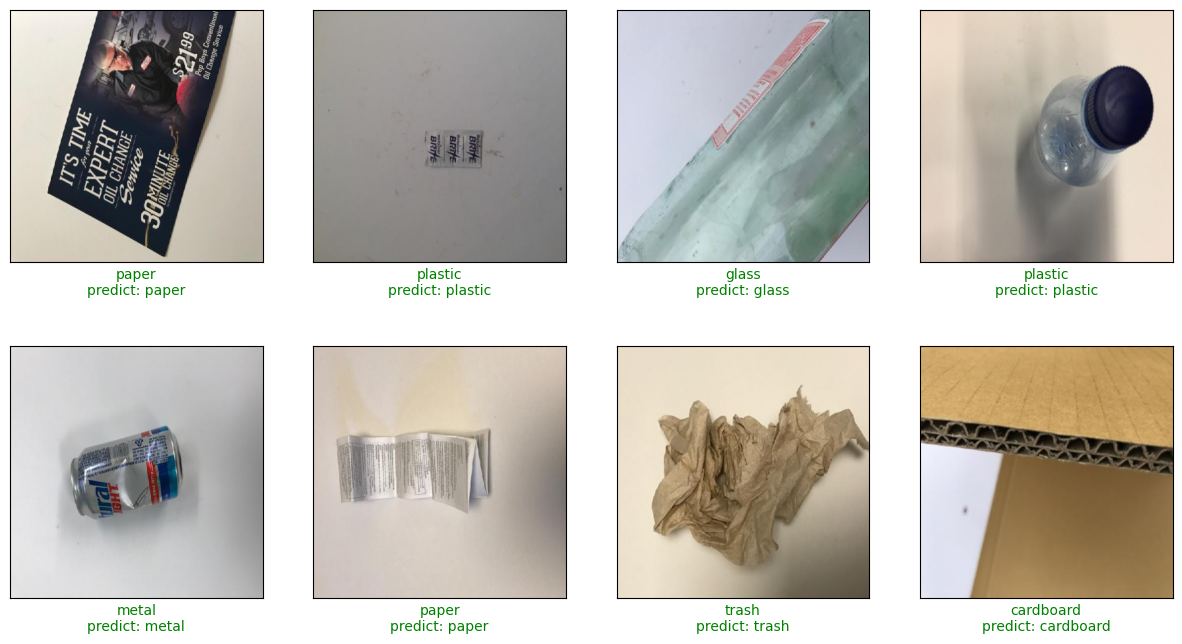

In [32]:
correct_predictions = 0
total_predictions = 0

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

for i in range(2):
    for j in range(4):
        random_index = np.random.randint(len(X_test))
        image = X_test[random_index]
        label_image = y_test[random_index]
        
        class_index = np.argmax(label_image)
        label_name = indices_to_class[class_index]

        # Predict the classes for the entire batch
        x = np.expand_dims(image, axis=0) # Thu ve 1 chieu
        classes = model.predict(x, verbose=0)
        pred_bintype = image_type[np.argmax(classes)]

        is_correct = label_name == pred_bintype
        correct_predictions += is_correct
        total_predictions += 1

        color = 'green' if is_correct else 'red'
        axs[i, j].imshow(image)  # Use the original image instead of img
        axs[i, j].set(xticks=[], yticks=[])
        axs[i, j].set_xlabel(f'{label_name}\npredict: {pred_bintype}', color=color)

accuracy = correct_predictions / total_predictions
print(f'Accuracy of test predictions: {accuracy * 100:.2f}%')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step
              precision    recall  f1-score   support

   cardboard       0.97      0.93      0.95        81
       glass       0.94      0.92      0.93       100
       metal       0.91      0.94      0.92        82
       paper       0.93      0.92      0.93       119
     plastic       0.91      0.93      0.92        97
       trash       0.76      0.81      0.79        27

    accuracy                           0.92       506
   macro avg       0.90      0.91      0.91       506
weighted avg       0.92      0.92      0.92       506





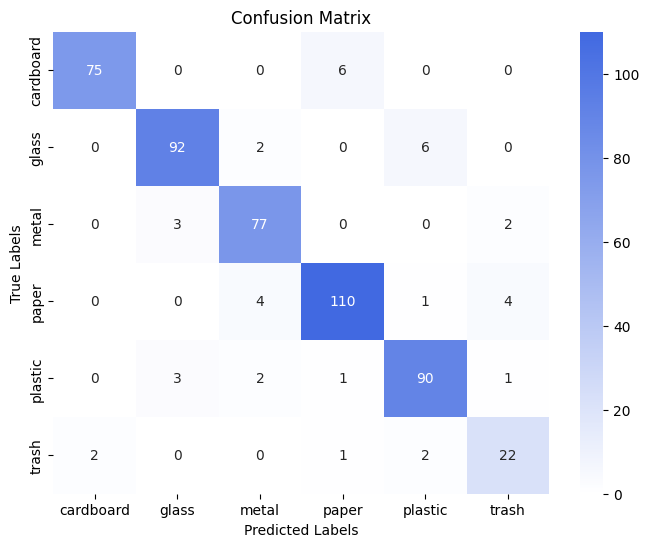

In [33]:
class_indices = validation_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

# Get true labels from validation generator
true_labels = []
for i in range(len(validation_generator)):
    _, batch_labels = validation_generator[i]
    true_labels.extend(batch_labels.argmax(axis=1))

predictions = model.predict(validation_generator)

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
report = classification_report(true_labels, predicted_labels, target_names=image_type)
print(report)
print('\n')

# Define a custom colormap
colors = ["white", "royalblue"]
cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=image_type, yticklabels=image_type)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()